*Top 250 French Movies*

### Overview
The "Top 250 French Movies" dataset comprises information on the highest-rated French movies according to user ratings on various platforms. This dataset contains 250 unique French movies that have garnered critical acclaim and popularity among viewers. Each movie is associated with essential details, including its rank, title, release year, duration, genre, IMDb rating, image source link, and a brief description.

### Data Analysis Tasks:

1.Exploratory Data Analysis (EDA):
Explore the distribution of movies by genres, release years, and IMDb ratings. Visualize the top-rated French movies and their IMDb ratings using bar charts or histograms.

2.Year-wise Trends:
Observe trends in French movie production over the years using line charts or area plots. Analyze if there's any correlation between release year and IMDb ratings.

3.Word Cloud Analysis:
Create word clouds from movie descriptions to visualize the most common words and themes among the top-rated French movies. This can provide insights into popular topics and genres.

4.Sentimental Analysis: Get the vibe of the audience by checking the sentiments in the "Desc" column. Find out what emotions the movie descriptions are stirring up and get a feel for the overall mood and intention behind them.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import string
import seaborn as sns
from collections import Counter

In [2]:
# Load the data
imdb = pd.read_csv('imdb.csv')

In [3]:
# Dataset has 250 entries and 15 columns. Some columns have missing values
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   web-scraper-order      250 non-null    object 
 1   web-scraper-start-url  250 non-null    object 
 2   Image-src              250 non-null    object 
 3   Name                   250 non-null    object 
 4   Rank                   250 non-null    int64  
 5   Year                   250 non-null    object 
 6   Type                   228 non-null    object 
 7   Duration               250 non-null    object 
 8   Genre                  250 non-null    object 
 9   Rating                 250 non-null    float64
 10  MetaScore              138 non-null    float64
 11  Desc                   250 non-null    object 
 12  Director_Stars         250 non-null    object 
 13  Votes                  1 non-null      object 
 14  Gross                  1 non-null      object 
dtypes: flo

In [4]:
# Drop the useless columns 
imdb = imdb.drop(['web-scraper-order', 'web-scraper-start-url', 'Image-src', 'Votes', 'Gross'], axis=1)

In [5]:
imdb.head()

,Name,Rank,Year,Type,Duration,Genre,Rating,MetaScore,Desc,Director_Stars
0,Shoah,1,-1985,PG,566 min,"Documentary, History, War",8.7,99.0,Claude Lanzmann's epic documentary recounts th...,Director:\nClaude Lanzmann\n |...
1,Home,2,(I) (2009),U,118 min,Documentary,8.5,47.0,"With aerial footage from fifty-four countries,...",Director:\nYann Arthus-Bertrand\n ...
2,Untouchable,3,-2011,15,112 min,"Biography, Comedy, Drama",8.5,57.0,After he becomes a quadriplegic from a paragli...,"Directors:\nOlivier Nakache, \nÉric Toledano\n..."
3,Le Trou,4,-1960,A,131 min,"Crime, Drama, Thriller",8.5,NaN,Distrust and uncertainty arise when four long-...,Director:\nJacques Becker\n | ...
4,The Man Who Planted Trees,5,-1987,NaN,30 min,"Animation, Short, Drama",8.5,NaN,The story of a shepherd's single handed quest ...,Director:\nFrédéric Back\n | \...


In [6]:
# Check duplicates
imdb.duplicated().sum()

0

### Missing values

In [7]:
count = imdb.isnull().sum().sort_values(ascending=False)
percentage = ((imdb.isnull().sum()/len(imdb)*100)).sort_values(ascending=False)
missing_data = pd.concat([count, percentage], axis=1, 
keys = ['Count', 'Percentage'])

print('Count and percantage of missing values for the columns:')

missing_data

Count and percantage of missing values for the columns:


,Count,Percentage
MetaScore,112,44.8
Type,22,8.8
Name,0,0.0
Rank,0,0.0
Year,0,0.0
Duration,0,0.0
Genre,0,0.0
Rating,0,0.0
Desc,0,0.0
Director_Stars,0,0.0


In [8]:
print(imdb['Type'].value_counts())
print(imdb['MetaScore'].value_counts())

Type
15       63
U        28
A        28
X        27
PG       26
12A      15
12       14
18       14
AA       10
PG-13     2
R         1
Name: count, dtype: int64
MetaScore
82.0     7
73.0     7
86.0     7
87.0     6
92.0     4
79.0     4
70.0     4
71.0     4
89.0     4
94.0     4
90.0     4
99.0     4
74.0     4
85.0     4
66.0     3
91.0     3
75.0     3
98.0     3
72.0     3
77.0     3
80.0     3
84.0     3
81.0     3
93.0     3
56.0     3
83.0     3
95.0     3
61.0     3
57.0     2
59.0     2
67.0     2
78.0     2
97.0     2
76.0     2
96.0     2
69.0     2
100.0    2
88.0     2
35.0     1
60.0     1
45.0     1
62.0     1
47.0     1
51.0     1
53.0     1
64.0     1
65.0     1
Name: count, dtype: int64


### Weighted Imputation

In [9]:
# Calculate the weights based on value frequencies for 'Type'
value_counts_type = imdb['Type'].value_counts()
weights_type = value_counts_type / value_counts_type.sum()

# Calculate the weights based on value frequencies for 'MetaScore'
value_counts_metascore = imdb['MetaScore'].value_counts()
weights_metascore = value_counts_metascore / value_counts_metascore.sum()

# Create an array of unique values with their corresponding weights for 'Type'
unique_values_type = weights_type.index.tolist()
unique_weights_type = weights_type.values.tolist()

# Create an array of unique values with their corresponding weights for 'MetaScore'
unique_values_metascore = weights_metascore.index.tolist()
unique_weights_metascore = weights_metascore.values.tolist()

# Create masks for missing values in both columns
type_mask = imdb['Type'].isnull()
metascore_mask = imdb['MetaScore'].isnull()

# Set a random seed for reproducibility
np.random.seed(42)

# Generate random imputations based on weights for 'Type'
imputations_type = np.random.choice(unique_values_type, size=type_mask.sum(), p=unique_weights_type)

# Generate random imputations based on weights for 'MetaScore'
imputations_metascore = np.random.choice(unique_values_metascore, size=metascore_mask.sum(), p=unique_weights_metascore)

# Create a copy of the DataFrame to avoid modifying the original data
imdb_imputed = imdb.copy()

# Assign the imputations to the missing values in the copy DataFrame for 'Type'
imdb_imputed.loc[type_mask, 'Type'] = imputations_type

# Assign the imputations to the missing values in the copy DataFrame for 'MetaScore'
imdb_imputed.loc[metascore_mask, 'MetaScore'] = imputations_metascore

# Verify the imputed values for 'Type'
imputed_values_type = imdb_imputed['Type'].loc[type_mask]
print("Imputed values for 'Type':")
print(imputed_values_type)

# Verify the imputed values for 'MetaScore'
imputed_values_metascore = imdb_imputed['MetaScore'].loc[metascore_mask]
print("Imputed values for 'MetaScore':")
print(imputed_values_metascore)

# Update the original DataFrame with the imputed values for 'Type'
imdb['Type'].update(imdb_imputed['Type'])

# Update the original DataFrame with the imputed values for 'MetaScore'
imdb['MetaScore'].update(imdb_imputed['MetaScore'])

Imputed values for 'Type':
4       U
41     AA
82     PG
117     X
137    15
140    15
141    15
153    12
183     X
186    PG
196    15
197    AA
199    12
205    15
215    15
219    15
221     U
224     X
230     A
232     U
245     X
246    15
Name: Type, dtype: object
Imputed values for 'MetaScore':
3      71.0
4      94.0
8      74.0
9      61.0
10     92.0
       ... 
232    91.0
233    99.0
234    92.0
242    86.0
245    89.0
Name: MetaScore, Length: 112, dtype: float64


In [10]:
# Check the distribution after imputation
print(imdb['Type'].value_counts())
print(imdb['MetaScore'].value_counts())

Type
15       71
U        31
X        31
A        29
PG       28
12       16
12A      15
18       14
AA       12
PG-13     2
R         1
Name: count, dtype: int64
MetaScore
73.0     14
82.0     14
86.0     14
89.0     11
87.0     10
91.0      8
71.0      8
61.0      8
92.0      8
79.0      7
70.0      7
59.0      7
99.0      7
74.0      7
80.0      7
94.0      7
75.0      6
56.0      5
95.0      5
85.0      5
77.0      5
90.0      5
83.0      5
69.0      5
66.0      5
100.0     4
57.0      4
76.0      4
81.0      4
72.0      4
88.0      4
98.0      4
93.0      4
96.0      3
47.0      3
84.0      3
67.0      3
97.0      3
78.0      2
64.0      2
35.0      2
60.0      2
62.0      1
45.0      1
51.0      1
53.0      1
65.0      1
Name: count, dtype: int64


In [11]:
imdb.isnull().sum()

Name              0
Rank              0
Year              0
Type              0
Duration          0
Genre             0
Rating            0
MetaScore         0
Desc              0
Director_Stars    0
dtype: int64

### Summary Statistics

In [12]:
# Describe 
imdb.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,250,250,Shoah,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rank,250.0,NaN,NaN,NaN,125.5,72.312977,1.0,63.25,125.5,187.75,250.0
Year,250,80,-2005,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,250,11,15,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Duration,250,83,105 min,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genre,250,73,Drama,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,250.0,NaN,NaN,NaN,7.6212,0.284807,7.2,7.4,7.6,7.8,8.7
MetaScore,250.0,NaN,NaN,NaN,79.064,13.126352,35.0,71.0,81.0,89.0,100.0
Desc,250,250,Claude Lanzmann's epic documentary recounts th...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Director_Stars,250,250,Director:\nClaude Lanzmann\n |...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Convert 'Duration' to numeric values
imdb['Duration'] = imdb['Duration'].str.extract('(\d+)').astype(float)

In [14]:
imdb['Year'].unique()

array(['-1985', '(I) (2009)', '-2011', '-1960', '-1987', '-1945', '-2001',
       '-2010', '-1962', '-1956', '-1902', '-1969', '-1995', '-1959',
       '-1994', '-2019', '-1953', '-1966', '(I) (2014)', '-1928', '-1967',
       '-1937', '-1955', '-2007', '-1952', '-1939', '-1986', '-1970',
       '-1958', '-1973', '-1983', '-1950', '-1963', '(I) (2011)', '-2009',
       '-2012', '-1993', '-2004', '-1972', '-2005', '-1946', '-1977',
       '-1974', '-1951', '-2017', '-1943', '-1980', '-2003', '-2013',
       '-1991', '-1964', '-2016', '-1961', '-1934', '-1938', '-2002',
       '-1996', '-1975', '-1954', '-1947', '-1929', '-1976', '-1998',
       '-1968', '-1971', '-2000', '-1992', '-1981', '-1988', '-1965',
       '-2008', '-1999', '-1982', '-1990', '-1989', '-2006', '-1997',
       '-1979', '-1932', '-2014'], dtype=object)

In [15]:
# Extract and clean the years using regular expressions
imdb['Year'] = imdb['Year'].apply(lambda x: re.search(r'\d{4}', x).group() if re.search(r'\d{4}', x) else None)

print(imdb['Year'].unique())

['1985' '2009' '2011' '1960' '1987' '1945' '2001' '2010' '1962' '1956'
 '1902' '1969' '1995' '1959' '1994' '2019' '1953' '1966' '2014' '1928'
 '1967' '1937' '1955' '2007' '1952' '1939' '1986' '1970' '1958' '1973'
 '1983' '1950' '1963' '2012' '1993' '2004' '1972' '2005' '1946' '1977'
 '1974' '1951' '2017' '1943' '1980' '2003' '2013' '1991' '1964' '2016'
 '1961' '1934' '1938' '2002' '1996' '1975' '1954' '1947' '1929' '1976'
 '1998' '1968' '1971' '2000' '1992' '1981' '1988' '1965' '2008' '1999'
 '1982' '1990' '1989' '2006' '1997' '1979' '1932']


### Distribution of Genre

<Axes: xlabel='count'>

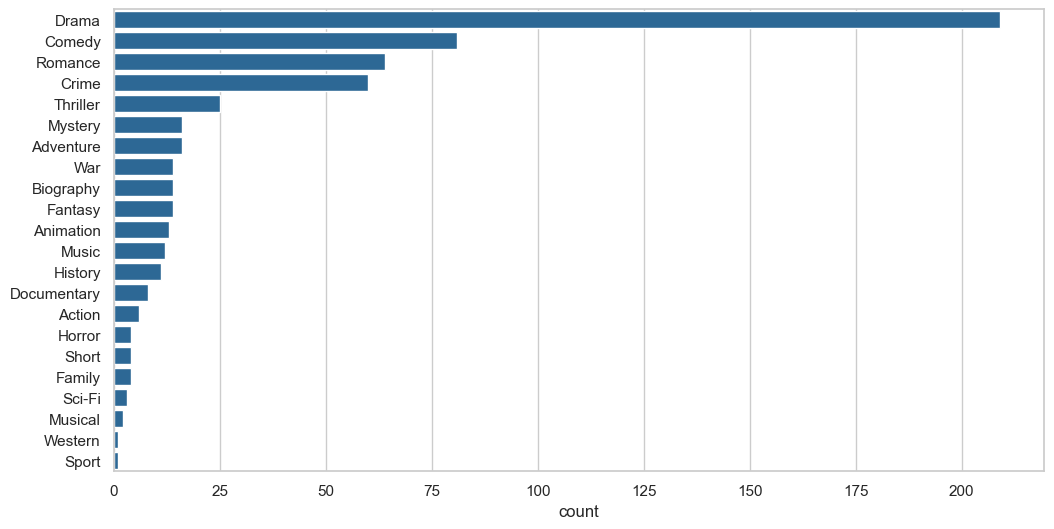

In [16]:
# Split the 'Genre' column into multiple genres
imdb['Genres'] = imdb['Genre'].str.split(', ')

# Create a DataFrame to count the frequency of each genre
genre_counts = pd.Series([genre for sublist in imdb['Genres'] for genre in sublist])

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.countplot(data=genre_counts, y=genre_counts, color="#1C6AA6", order=genre_counts.value_counts().index)

### Distribution of Ratings

<Axes: xlabel='Rating', ylabel='count'>

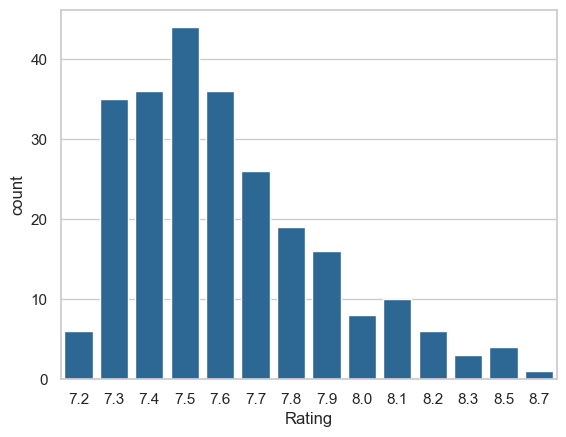

In [17]:
sns.countplot(data=imdb, x="Rating", color = '#1C6AA6')

### Top-rated French movies and their IMDb ratings 

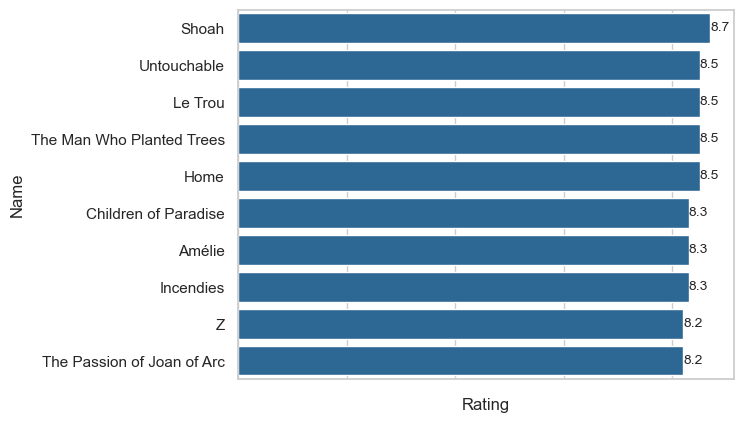

In [18]:
top_rated_french_movies = imdb.sort_values(by='Rating', ascending=False).head(10)
sns.set(style="whitegrid")

ax = sns.barplot(top_rated_french_movies, x="Rating", y="Name", color="#1C6AA6", estimator="sum", errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10);
ax.set_xticklabels([])
plt.show()

### Distribution of Release Years

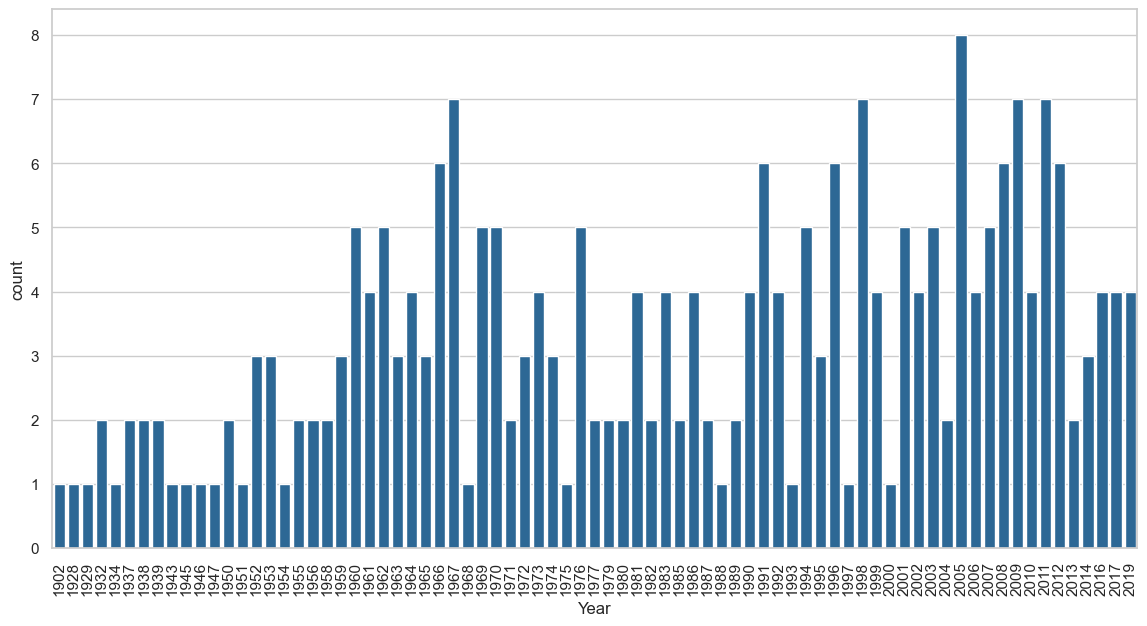

In [19]:
plt.figure(figsize=(14, 7))

sort_years = imdb.sort_values(by='Year', ascending=True)

sns.countplot(data=sort_years, x="Year", color="#1C6AA6")
plt.xticks(rotation=90) 
plt.show()

### Year-wise Trends (Correlation between Year and, IMDB rating)

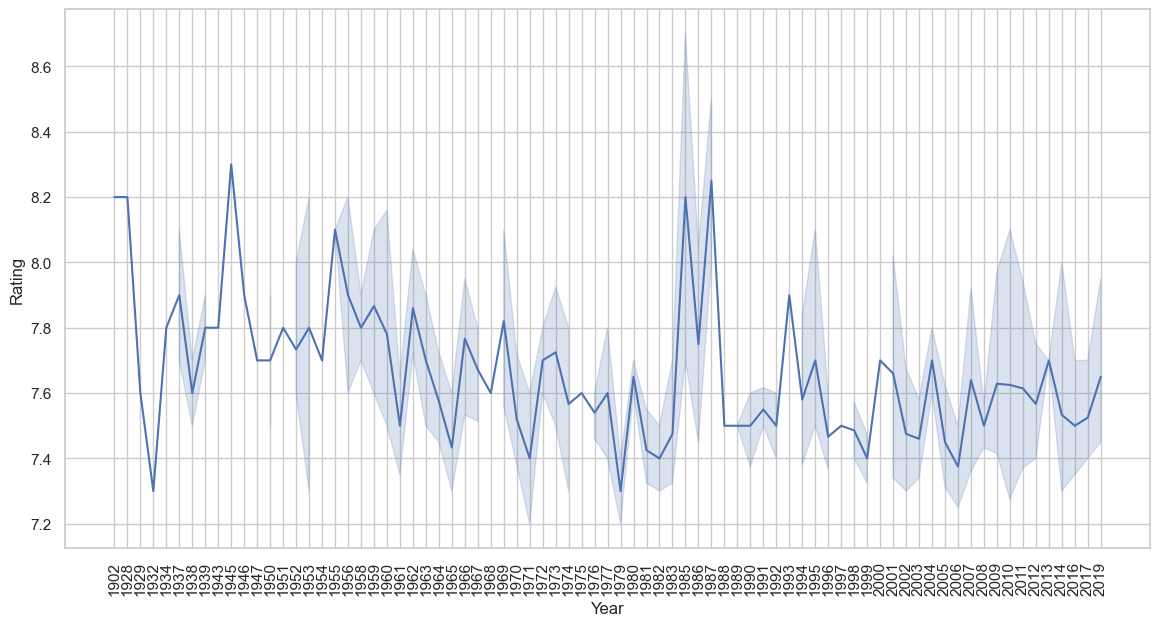

In [20]:
year_rating = imdb.sort_values(by='Year', ascending=True)

plt.figure(figsize=(14,7))

sns.lineplot(data=year_rating, x="Year", y="Rating")
plt.xticks(rotation=90)
plt.show()

### Description Word Cloud Analysis

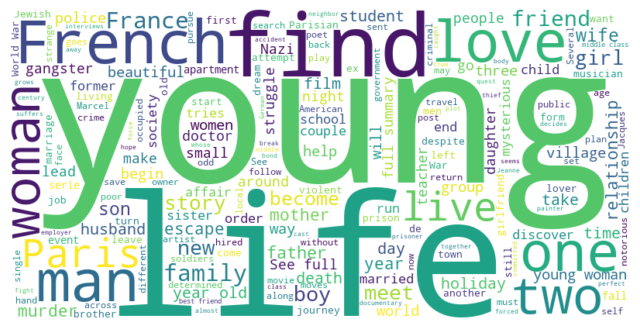

In [21]:
# Concatenate all movie descriptions into a single string
all_descriptions = ' '.join(imdb['Desc'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_descriptions)

# Plot the word cloud
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Sentimental Analysis 

### Lower case

In [22]:
lower_case = imdb['Desc'].str.lower()

In [23]:
lower_case

0      claude lanzmann's epic documentary recounts th...
1      with aerial footage from fifty-four countries,...
2      after he becomes a quadriplegic from a paragli...
3      distrust and uncertainty arise when four long-...
4      the story of a shepherd's single handed quest ...
                             ...                        
245    the life of octave parango, a flamboyant ad de...
246    vincent is about to become a father. at a meet...
247    she is almost deaf and he lip-reads. he is an ...
248    a journalist covering police assigned to a juv...
249    in paris, a turkish shop owner befriends a jew...
Name: Desc, Length: 250, dtype: object

### Remove the punctuations

In [24]:
# Review all the punctuations.
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [25]:
cleaned_text = lower_case.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
print(cleaned_text)

0      claude lanzmanns epic documentary recounts the...
1      with aerial footage from fiftyfour countries h...
2      after he becomes a quadriplegic from a paragli...
3      distrust and uncertainty arise when four longt...
4      the story of a shepherds single handed quest t...
                             ...                        
245    the life of octave parango a flamboyant ad des...
246    vincent is about to become a father at a meeti...
247    she is almost deaf and he lipreads he is an ex...
248    a journalist covering police assigned to a juv...
249    in paris a turkish shop owner befriends a jewi...
Name: Desc, Length: 250, dtype: object


### Tokenization

In [26]:
%%capture

tokenized_words = cleaned_text.str.split()

for words_list in tokenized_words:
    for word in words_list:
        print(f"'{word}'")

### Stop words

In [27]:
%%capture

stop_words = set()
with open("stopwords", "r") as file:
    for line in file:
        stop_words.add(line.strip())

filtered_words = []

for words_list in tokenized_words:
    for word in words_list:
        if word not in stop_words:
            filtered_words.append(word)

print(filtered_words)

In [28]:
emotion_list = []
with open('emotions.txt', 'r') as file: 
    for line in file: 
        clear_line = line.replace("\n", '').replace(",", '').replace("'", '').strip()
        word, emotion = clear_line.split(':')
        #print("Word :" + word + " " + "Emotion :" + emotion)
        
        if word in filtered_words: 
            emotion_list.append(emotion)
print(emotion_list)

[' cheated', ' angry', ' sad', ' bored', ' attracted', ' attached', ' fearless', ' attracted', ' sad', ' focused', ' demoralized', ' sad', ' sad', ' powerless', ' free', ' happy', ' sad', ' entitled', ' attracted', ' alone', ' attracted', ' bored', ' alone', ' attached', ' attracted', ' obsessed', ' sad', ' average', ' sad', ' adequate', ' sad', ' fearful', ' derailed', ' sad', ' entitled', ' fearful', ' happy', ' fearful', ' hated', ' powerless', ' codependent', ' alone', ' focused', ' happy', ' happy', ' loved', ' anxious', ' entitled', ' sad']


In [29]:
w = Counter(emotion_list)
print(w)

Counter({' sad': 10, ' attracted': 5, ' happy': 4, ' entitled': 3, ' alone': 3, ' fearful': 3, ' bored': 2, ' attached': 2, ' focused': 2, ' powerless': 2, ' cheated': 1, ' angry': 1, ' fearless': 1, ' demoralized': 1, ' free': 1, ' obsessed': 1, ' average': 1, ' adequate': 1, ' derailed': 1, ' hated': 1, ' codependent': 1, ' loved': 1, ' anxious': 1})


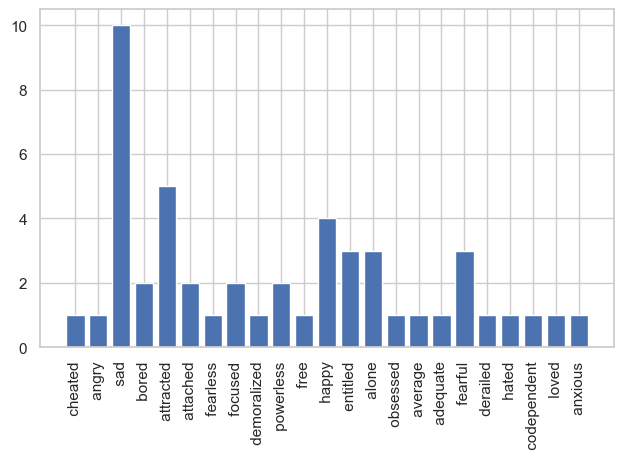

In [30]:
fig, ax1 = plt.subplots()
ax1.bar(w.keys(), w.values())
plt.xticks(range(len(w)), rotation=90)
fig.tight_layout()
plt.savefig('graph.png')
plt.show()